<a href="https://colab.research.google.com/github/Vanshree005/FUTURE_ML_02/blob/main/ml_2_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

df =  pd.read_csv('ADANIPORTS.csv')
df = df [['Date','Close']]
import datetime
def str_to_datetime(s):
  split =s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)
datetime_object = str_to_datetime('1980-12-12')
datetime_object

datetime.datetime(1980, 12, 12, 0, 0)

In [3]:
df['Date']= df['Date'].apply(str_to_datetime)
df['Date']

,Date
0,2007-11-27
1,2007-11-28
2,2007-11-29
3,2007-11-30
4,2007-12-03
...,...
3317,2021-04-26
3318,2021-04-27
3319,2021-04-28
3320,2021-04-29


In [4]:
df.index = df.pop('Date')
df

,Close
Date,
2007-11-27,962.90
2007-11-28,893.90
2007-11-29,884.20
2007-11-30,921.55
2007-12-03,969.30
...,...
2021-04-26,730.75
2021-04-27,749.15
2021-04-28,746.25


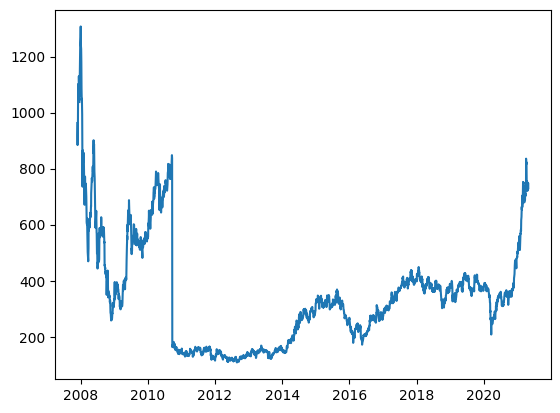

In [5]:
import matplotlib.pyplot as plt
plt.plot(df.index, df['Close'])


In [7]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
 first_date = str_to_datetime(first_date_str)
 last_date  = str_to_datetime(last_date_str)

 target_date = first_date
 dates = []
 X, Y = [], []

 last_time = False
 while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

 ret_df = pd.DataFrame({})
 ret_df['Target Date'] = dates

 X = np.array(X)
 for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

 ret_df['Target'] = Y

 return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2019-03-25',
                                '2021-03-24',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2019-03-25,365.75,360.60,360.75,361.35
1,2019-03-26,360.60,360.75,361.35,368.60
2,2019-03-27,360.75,361.35,368.60,366.30
3,2019-03-28,361.35,368.60,366.30,381.30
4,2019-03-29,368.60,366.30,381.30,378.15
...,...,...,...,...,...
492,2021-03-18,719.05,717.35,688.25,679.65
493,2021-03-19,717.35,688.25,679.65,686.25
494,2021-03-22,688.25,679.65,686.25,721.90
495,2021-03-23,679.65,686.25,721.90,738.55


In [8]:
def windowed_df_to_date_x_y(windowed_dataframe):

  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  x = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
  y = df_as_np[:, -1]

  return dates, x.astype(np.float32), y.astype(np.float32)

dates, x, y = windowed_df_to_date_x_y(windowed_df)
dates.shape, x.shape, y.shape


((497,), (497, 3, 1), (497,))

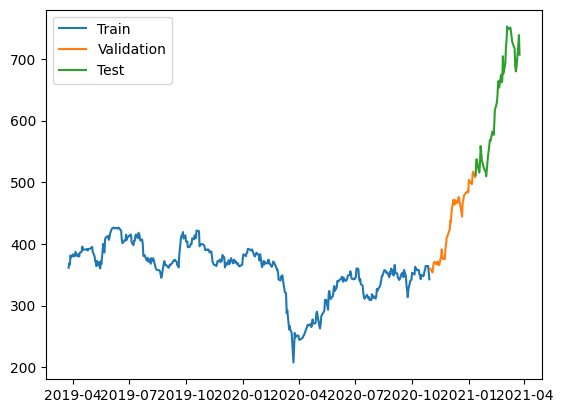

In [9]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, x_train, y_train = dates[:q_80], x[:q_80], y[:q_80]

dates_val, x_val, y_val = dates[q_80:q_90], x[q_80:q_90], y[q_80:q_90]
dates_test, x_test, y_test = dates[q_90:], x[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 128718.9297 - mean_absolute_error: 356.1714 - val_loss: 188533.8594 - val_mean_absolute_error: 430.9733
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 129529.2734 - mean_absolute_error: 357.7303 - val_loss: 186640.4844 - val_mean_absolute_error: 428.7713
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 124016.3672 - mean_absolute_error: 349.5237 - val_loss: 183695.7656 - val_mean_absolute_error: 425.3188
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 125371.6875 - mean_absolute_error: 351.8109 - val_loss: 178851.7188 - val_mean_absolute_error: 419.5823
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 118998.4844 - mean_absolute_error: 342.5538 - val_loss: 170737.2812 - val_mean_absolute_error: 409.7998
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 111200.6172 - mean_absolute_error: 330.8515 - val_loss: 159800.4531 - val_mean_absolute_error: 396.2387
Epoch 7/100
13/13 ━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


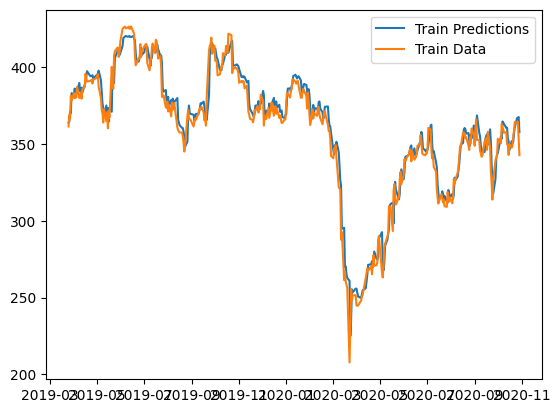

In [11]:
train_predictions = model.predict(x_train).flatten()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Train Predictions', 'Train Data'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


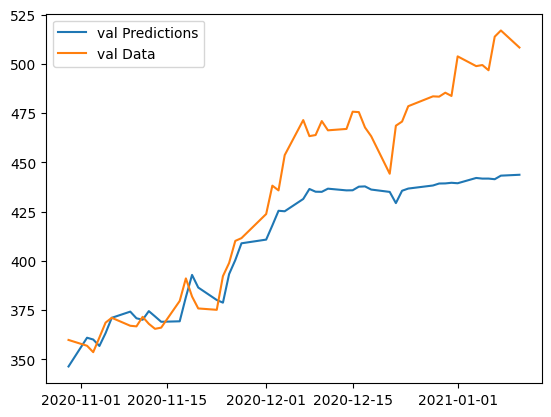

In [12]:
val_predictions = model.predict(x_val).flatten()
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['val Predictions', 'val Data'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


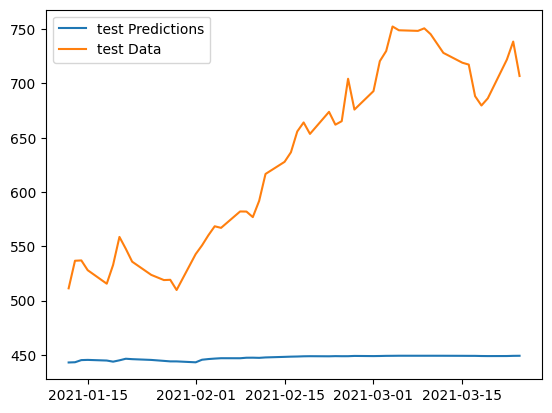

In [13]:
test_predictions = model.predict(x_test).flatten()
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['test Predictions', 'test Data'])

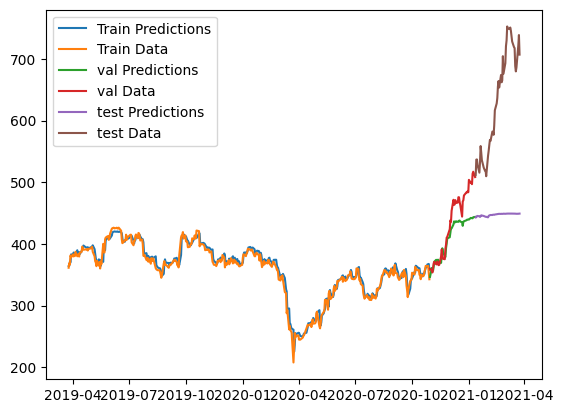

In [14]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Train Predictions', 'Train Data',
    'val Predictions', 'val Data',
    'test Predictions', 'test Data'])

In [15]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(x_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

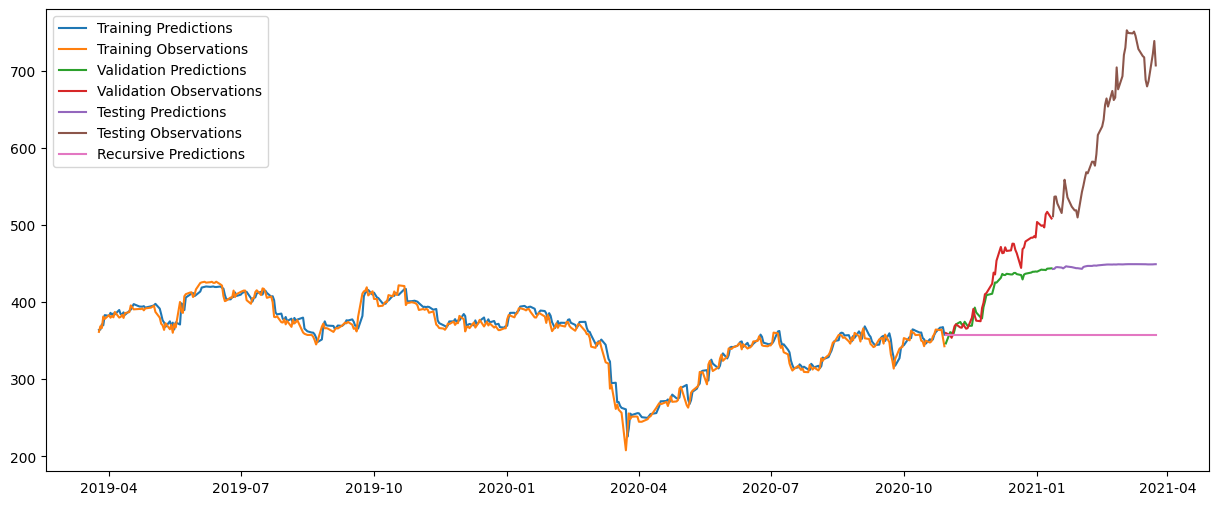

In [17]:
plt.figure(figsize=(15, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])